In [5]:
import math

def phi(x):
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x**2)

def CDF(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

In [6]:
import numpy as np

def ImpliedVolatility(S, K, r, T, C_mkt):

    # ATM Formula — Brenner & Subrahmanyam, for calls when r ≈ 0)
        sigma_cur = (2 * np.pi) ** 0.5 * (C_mkt / (S * T ** 0.5))
    
    # Standard 80% volatility
        #sigma_cur = 0.8

        for i in range(10):
            d_1 = (np.log(S / K) + (r + 0.5 * sigma_cur ** 2) * T) / (sigma_cur * T ** 0.5)
            d_2 = d_1 - sigma_cur * T ** 0.5
            vega = S * T ** 0.5 * phi(d_1)
            C_bs = S * CDF(d_1) - K * np.exp(-r * T) * CDF(d_2)
        
            sigma_new = sigma_cur - ((C_bs - C_mkt) / vega)
            sigma_dif = sigma_new - sigma_cur
            sigma_cur = sigma_new

             if abs(sigma_dif) < tol:
                break
        
        return sigma_cur

In [35]:
def CalculateCallPrice(S, K, r, T, C_mkt):
    # Step 1: Compute implied volatility
    vol = ImpliedVolatility(S, K, r, T, C_mkt)

    # Step 2: Precompute parameters
    dt = T / N
    drift_dt = (r - 0.5 * vol**2) * dt
    vol_sqrt_dt = vol * np.sqrt(dt)
    log_S0 = np.log(S)

    # Step 3: Monte Carlo simulation of log price paths
    Z = np.random.normal(size=(N, M))         # random shocks
    log_returns = drift_dt + vol_sqrt_dt * Z  # log returns
    log_paths = log_S0 + np.cumsum(log_returns, axis=0)
    log_paths = np.vstack((np.full((1, M), log_S0), log_paths))  # include initial price

    # Step 4: Convert log prices to actual prices
    asset_paths = np.exp(log_paths)

    # Step 5: Calculate option payoff at maturity
    call_payoffs = np.maximum(0, asset_paths[-1] - K)
    call_price = np.exp(-r * T) * np.mean(call_payoffs)

    # Step 6: Calculate standard error
    payoff_std = np.std(call_payoffs, ddof=1)
    std_error = payoff_std / np.sqrt(M)

    # Step 7: Extract one sample path
    sample_path = asset_paths[:, 0]

    # Step 8: Return results
    return np.round(call_price, 2), np.round(std_error, 2), sample_path

In [36]:
# === USER INPUT PARAMETERS ===
S = 111026           # underlying price
K = 100000           # strike price
r = 0.01             # interest rate
T = 1 / 365          # time to expiration in years
N = 30               # number of time steps
M = 1000             # number of simulations
C_mkt = 11059        # market option price in USD (converted)
# ============================

C0_vector = np.zeros(M)
SE_vector = np.zeros(M)
ST_matrix = np.zeros((N + 1, M))   # each column = one St path over time

for i in range(M):
    C0, SE, St_path = CalculateCallPrice(S, K, r, T, C_mkt)
    C0_vector[i] = C0
    SE_vector[i] = SE
    ST_matrix[:, i] = St_path   # ✅ put the whole path into column i
    
print("Done.")
print("C0 mean:", np.mean(C0_vector))
print("SE mean:", np.mean(SE_vector))
print("ST_matrix shape:", ST_matrix.shape)   # (N+1, 1000)

Done.
C0 mean: 11052.30668
SE mean: 169.82663
ST_matrix shape: (31, 1000)


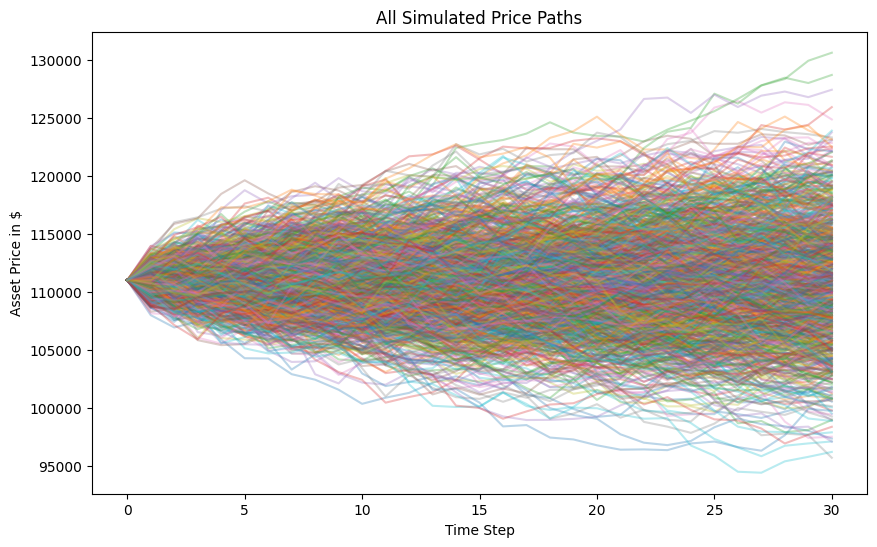

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))  # Makes the plot larger; can remove if desired

for i in range(ST_matrix.shape[1]):   # Loop over each column (each simulation path)
    plt.plot(ST_matrix[:, i], alpha=0.3)  # alpha adds transparency so lines don't completely overlap

plt.title("All Simulated Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Asset Price in $")
plt.show()

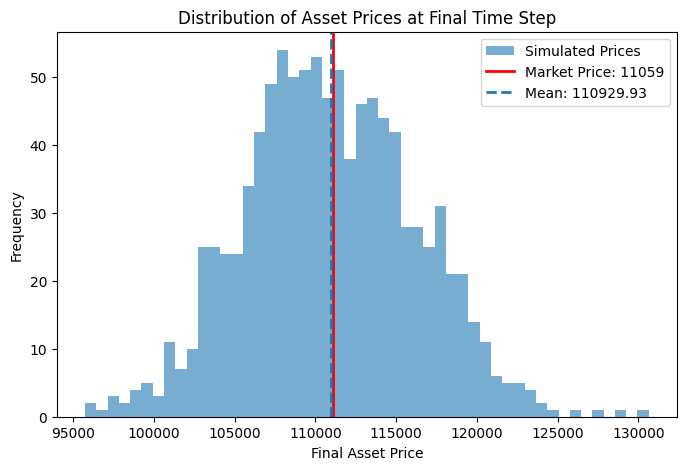

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Extract final simulated prices
final_prices = ST_matrix[-1, :]

# Calculate statistics
mean_final_price = np.mean(final_prices)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(final_prices, bins=50, alpha=0.6, label='Simulated Prices')

# Add vertical lines
plt.axvline(C_mkt + K, color='red', linestyle='solid', linewidth=2, label=f"Market Price: {C_mkt}")
plt.axvline(mean_final_price, linestyle='dashed', linewidth=2, label=f"Mean: {mean_final_price:.2f}")

# Add labels and legend
plt.title("Distribution of Asset Prices at Final Time Step")
plt.xlabel("Final Asset Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [40]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
